
Spark streaming


In [1]:

from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    .config("spark.sql.streaming.schemaInference", True)
    .getOrCreate()
)

stream = (
    spark
    .readStream
    .format("ws")
    .option("schema", "ticker")
    .load()
)

query = (
    stream
    .select("side", "product_id", "last_size", "best_bid", "best_ask", "time")
    .writeStream
    .format("console")
    .outputMode("append")
    .option("truncate", "false")
    .start()
)

query.awaitTermination(10)
query.stop()
stream.printSchema()


root
 |-- type: string (nullable = false)
 |-- trade_id: long (nullable = false)
 |-- sequence: long (nullable = false)
 |-- time: timestamp (nullable = false)
 |-- product_id: string (nullable = false)
 |-- price: double (nullable = false)
 |-- side: string (nullable = false)
 |-- last_size: double (nullable = false)
 |-- best_bid: double (nullable = false)
 |-- best_ask: double (nullable = false)



In [19]:


# panic button - press only if you messed up opening new websocket and lost reference to it

query.stop()
spark.stop()



     




Uruchamiająć stream.start() uruchamiamy w osobnym demonie websocket który streamuje wyniki. Jeżeli wystąpi jakiś błąd po stronie front-endu (np. błąd parsowania kolejnej linijki Pythona) fakt ten nie zostanie zgłoszony do sparka i socket pozostanie otwarty! Należy pamiętać, by zamykać stream za każdym razem używająć metody stop() (w powyższym przykładzie query.stop()). W przypadku utracenia referencji do zapytania, należy zastopować całą sesję również metodą stop() (w powyższym przykładzie spark.stop())


# Zadanie 1

Analiza strumienia danych CoinBase (3p). Napisz zapytanie, które wypisuje średnią wartość wybranego parametru (np. price) w przesuwnych oknach czasowych względem czasu transakcji (kolumna time), grupując po relacji wymiany (z jakiej waluty na jaką walutę - kolumna product_id).

In [2]:

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = (
    SparkSession
    .builder
    .config("spark.sql.streaming.schemaInference", True)
    .config("spark.sql.streaming.forceDeleteTempCheckpointLocation", True)
    .getOrCreate()
)

stream = (
    spark
    .readStream
    .format("ws")
    .option("schema", "ticker")
    .load()
)


query = (
    stream
    .select("product_id", "price", "time")
    .groupBy(F.window("time", "2 minutes", "1 minutes"), "product_id").mean("price")
    .orderBy("window")
)

query = (
    query
    .writeStream
    .format("console")
    .outputMode("complete")
    .option("truncate", "false")
    .start()
)

query.awaitTermination(10)
query.stop()




Window ma 3 parametry :

    timeColumn, dla nas kolumna "time"
    windowDuration - rozmiar okna
    slideDuration - sposób poruszania się okien

Grupujemy według okna i id produktu, liczymy średnią z price w oknach czasowych


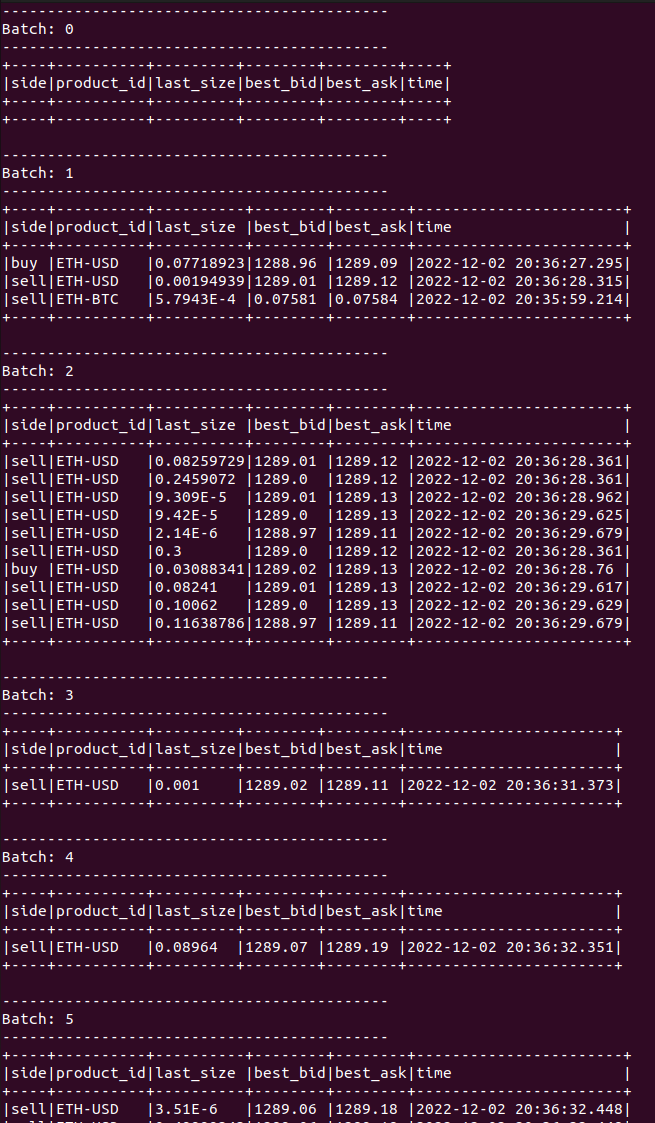

In [11]:


from IPython.display import Image
display(Image(data=open('zad_1.png','rb').read(), format='png'))



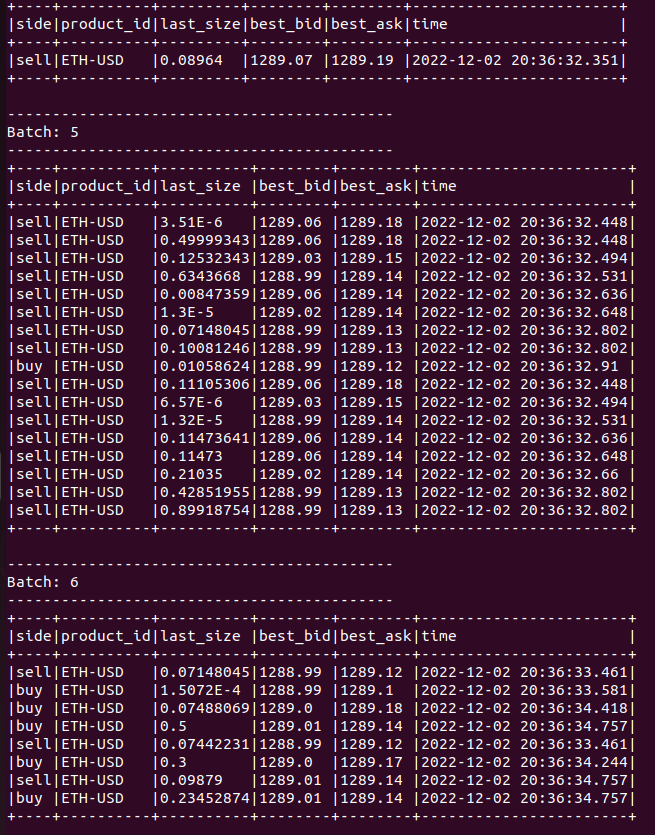

In [12]:
display(Image(data=open('zad_2.png','rb').read(), format='png'))


# Zadanie 2

Watermarking i dane opóźnione (3p). Zmodyfikuj zapytanie z zadania 1 tak, aby zademonstować mechanizm znaków wodnych (watermarks) i obsługi danych opóźnionych. W konsoli powinno być widać, że aktualizują się odpowiednie wiersze tabeli wynikowej (tryb update), w szczególności aktualizacja wcześniejszych okien czasowych po przybyciu danych opóźnionych. Do rozwiązania tego zadania proszę dołączyć przykładowy output i jego opis wyjaśniający na konkretnym przykładzie działanie znaku wodnego i danych opóźnionych.

Do ćwiczenia można wykorzystać skrypt w katalogu /mock napisany w Scala-cli, który posłuży jako kontrolowane źródło danych CoinBase przez Websocket.

Skrypt można uruchomić wykorzystując Docker:

make image
make run

Spowoduje to utworzenie websocketowego serwera pod adresem ws://mock:8025

Po uruchomieniu serwera należy wykonać poniższą komórkę, w której zapytanie czyta dane z utworzonego websocketa. Skrypt wysyła przykładowe wiadomości w formacie CoinBase co 10 sekund:

    W pierwszej serii wysyłane wiadomości o znacznikach czasowych 0s, 14s, 7s
    W drugiej serii wysyłane są wiadomości o znacznikach czasowych 15s, 8s, 21s
    W trzeciej serii wysyłane są wiadomości o znacznikach czasowych 4s, 17s

Dla tych danych można ustawić okno czasowe na interwał 10 sekund. Skrypt można też zmodyfikować, tak aby wysyłał inne dane.

In [13]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F


spark = (
    SparkSession
    .builder
    .config("spark.sql.streaming.schemaInference", True)
    .getOrCreate()
)

stream = (
    spark
    .readStream
    .format("ws")
    .option("schema", "ticker")
    .option("url", "ws://mock:8025")
    .load()
)


query = (
    stream
    .select("product_id", "price", "time")
    .withWatermark("time", "30 seconds")
    .groupBy(F.window("time", "10 seconds", "5 seconds"), "product_id").mean("price")
)

query = (
    query
    .writeStream
    .format("console")
    .outputMode("update")
    .option("truncate", "false")
    .start()
)

query.awaitTermination(40)
query.stop()

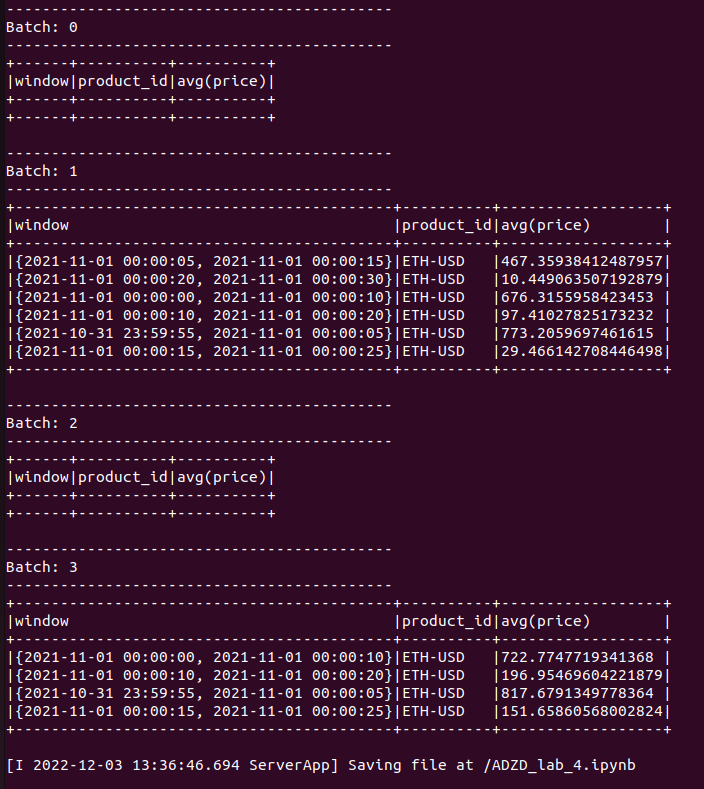

In [2]:
from IPython.display import Image

display(Image(data=open('1.png','rb').read(), format='png'))


# Zadanie 3

Łączenie strumieni (3p). Rozdziel sztucznie dane CoinBase z kanału ticker na dwa strumienie (wykorzystując filtrowanie subskrypcji): jeden strumień dla side="sell", drugi dla side="buy". Następnie stwórz zapytanie, które łączy te strumienie i wypisuje transakcje dla danego product_id, które występowały po sobie w ciągu 1s.

In [18]:
from pyspark.sql import SparkSession

spark = SparkSession.\
    builder.\
    config("spark.sql.streaming.schemaInference", True).\
    config("spark.sql.streaming.forceDeleteTempCheckpointLocation", True).\
    getOrCreate()  

stream = spark.\
    readStream.\
    format("ws").\
    option("schema", "ticker").\
    load()

sell = (
    stream
    .select("side", "product_id", "price", "time")
    .filter(stream.side == "sell")
    .withColumnRenamed("side", "sell_side")
    .withColumnRenamed("product_id", "sell_product_id")
    .withColumnRenamed("price", "sell_price")
    .withColumnRenamed("time", "sell_time")
)


buy = (
    stream
    .select("side", "product_id", "price", "time")
    .filter(stream.side == "buy")
    .withColumnRenamed("side", "buy_side")
    .withColumnRenamed("product_id", "buy_product_id")
    .withColumnRenamed("price", "buy_price")
    .withColumnRenamed("time", "buy_time")
)


joined = (
    sell.join(
        buy,
        F.expr(
            """
            buy_product_id = sell_product_id AND
            buy_time >= sell_time AND
            buy_time <= sell_time + interval 1 seconds
            """
        )
    )
)

query = (
    joined
    .writeStream
    .format("console")
    .outputMode("append")
    .option("truncate", "false")
    .start()
)

query.awaitTermination(60)
query.stop()

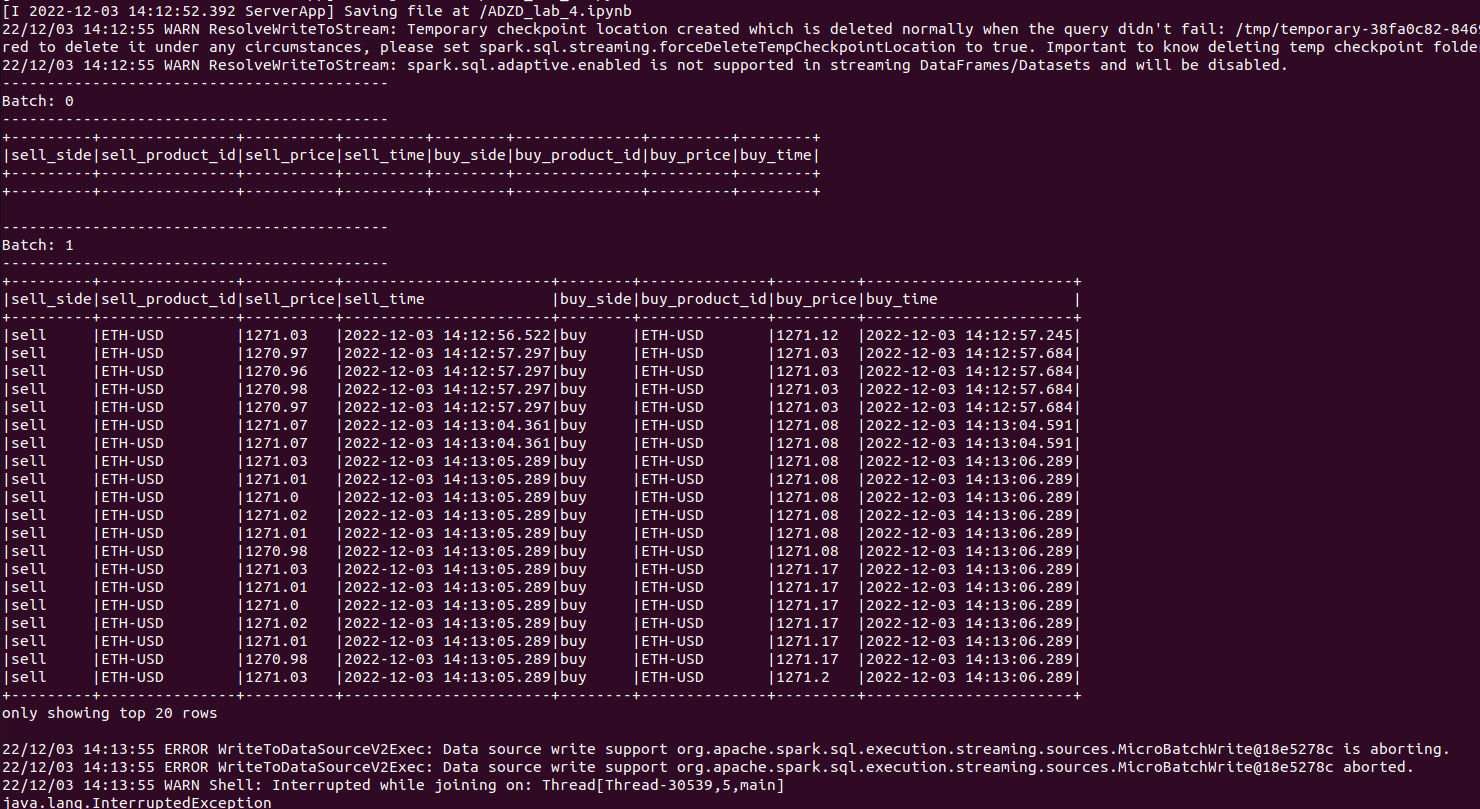

In [3]:
display(Image(data=open('2.png','rb').read(), format='png'))
